<h3>Gan Implementation from scratch</h3>

Importing the required librarys

In [4]:
from torch import nn
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision
from matplotlib import pyplot as plt

Defining the discriminator and generator


In [5]:
class Discrimator(nn.Module):
  #The type of model that discriminates images of the generator
  def __init__(self,img_dim):
    super(Discrimator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(img_dim,128),
        nn.ReLU(),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.model(x)

class Generator(nn.Module):
  #Generates images from a noise
  def __init__(self,latent_dim,img_dim):
    super(Generator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.ReLU(),
        nn.Linear(256,img_dim),
        nn.Tanh()
    )
  def forward(self,x):
    return self.model(x)

Defining hyperparameters

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
latent_dim = 256
img_dim = 28*28*1 #MNIST - Datashape
batch_size = 32
num_epochs = 50

In [7]:
disc = Discrimator(img_dim).to(device)
gen = Generator(latent_dim,img_dim).to(device)
fixed_noise = torch.randn((batch_size,latent_dim)).to(device)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5),(0.5))]
)

In [8]:
dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


100%|██████████| 9912422/9912422 [00:00<00:00, 78463243.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103800937.30it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27000434.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9283883.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
opt_disc = torch.optim.Adam(disc.parameters(),lr=lr)
opt_gen = torch.optim.Adam(gen.parameters(),lr=lr)
criterion= nn.BCELoss()

Training loop

In [10]:
for epoch in range(num_epochs):
  for iter, (real,_) in enumerate(loader):
    #Loss : log(D(X)) + log(1-D(G(Z)))
    real = real.view(batch_size,-1).to(device) #flatten it to 784
    noise = torch.randn(batch_size,latent_dim).to(device)
    fake = gen(noise) #G(Z)
    disc_real = disc(real).view(-1)#D(X)
    lossD_real = criterion(disc_real,torch.ones_like(disc_real)) #log(D(X))

    disc_fake = disc(fake).view(-1) #D(G(Z))
    #removing the first part(ylog(D(x))) of the loss function, and havig the (1-yn)*log(1-D(G(Z))) part of our expression(since we are passing in zeros)
    lossD_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
    lossD = (lossD_real+lossD_fake)/2
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    #train generator (1-D(G(Z)))
    output = disc(fake).view(-1)
    lossG = criterion(output,torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

  print(f"Epoch : {epoch+1}/{num_epochs} completed")


Epoch : 1/50 completed
Epoch : 2/50 completed
Epoch : 3/50 completed
Epoch : 4/50 completed
Epoch : 5/50 completed
Epoch : 6/50 completed
Epoch : 7/50 completed
Epoch : 8/50 completed
Epoch : 9/50 completed
Epoch : 10/50 completed
Epoch : 11/50 completed
Epoch : 12/50 completed
Epoch : 13/50 completed
Epoch : 14/50 completed
Epoch : 15/50 completed
Epoch : 16/50 completed
Epoch : 17/50 completed
Epoch : 18/50 completed
Epoch : 19/50 completed
Epoch : 20/50 completed
Epoch : 21/50 completed
Epoch : 22/50 completed
Epoch : 23/50 completed
Epoch : 24/50 completed
Epoch : 25/50 completed
Epoch : 26/50 completed
Epoch : 27/50 completed
Epoch : 28/50 completed
Epoch : 29/50 completed
Epoch : 30/50 completed
Epoch : 31/50 completed
Epoch : 32/50 completed
Epoch : 33/50 completed
Epoch : 34/50 completed
Epoch : 35/50 completed
Epoch : 36/50 completed
Epoch : 37/50 completed
Epoch : 38/50 completed
Epoch : 39/50 completed
Epoch : 40/50 completed
Epoch : 41/50 completed
Epoch : 42/50 completed
E

Viewing a random generated image

In [20]:
noise_test = torch.randn(1,latent_dim).to(device)
fake_test = gen(noise_test).cpu().view(28,28).detach().numpy()
# plt.imshow(fake_test)

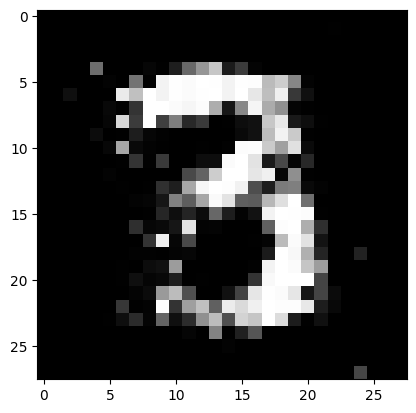

In [21]:
plt.imshow(fake_test,cmap="gray")